*Luis Antonio Ortega Andrés   
Antonio Coín Castro*

# Teoría de la Información - Práctica

## Planteamiento del problema

(Introducción, series, codificación, ...)

sabemos que habrá pocos spikes
voltaje

Veamos paso a paso como modelamos los datos y resolvemos el problema.

## Cargar paquetes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.signal import find_peaks
from sklearn.preprocessing import normalize
import seaborn as sns
from time import time
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import multiprocessing
import contextlib
import joblib

## Leer archivos

Leemos los tres archivos de los que disponemos, cada uno de ellos correspondientes a las dos series temporales que nos interesan en los estados de control, inyección de Gaba y recuperación. Para el estado en inyección de Gaba, no consideramos la tercera columna con los valores del tiempo de inyección.

Utilizaremos como estructura de datos un *dataframe* de la librería `Pandas`, que nos permite leer y manejar los datos de forma bastante cómoda.

In [2]:
trozoC = pd.read_csv("TrozoC.txt", names = ["LP", "VD"], 
                     delimiter = "\t", skiprows = range(3), 
                     index_col = False, decimal = ",")

In [3]:
trozoG = pd.read_csv("TrozoG.txt", names = ["LP", "VD"],
                     usecols = [0, 1],
                     delimiter = "\t", skiprows = range(3), 
                     index_col = False, decimal = ",")

In [4]:
trozoR = pd.read_csv("TrozoR.txt", names = ["LP", "VD"], 
                     delimiter = "\t", skiprows = range(3), 
                     index_col = False, decimal = ",")

En primer lugar trabajaremos únicamente con uno de los trozos (`trozoC`), donde detallaremos todas las operaciones y cálculos que hacemos, y posteriormente repetiremos estos cálculos en los otros dos trozos.

## Establecer umbral

El primer paso que debemos realizar es establecer para cada señal un umbral o *threshold* a partir del cual consideraremos que se ha producido un *spike*. Para ello nos basaremos primero en un criterio estadístico para elegir un umbral preliminar, y en vista de los resultados lo ajustaremos manualmente hasta un valor que consideremos razonable.

Para esta primera elección del umbral ($\theta$) se ha seguido un procedimiento de ensayo-error: como primera estrategia, hemos probado a utilizar el rango intercuartílico de la secuencia, esto es, la distancia entre el valor que deja por encima el $75$% de los valores y el que deja el $25$%, multiplicado por $1.5$. El resultado era demasiado conservador, pues consideraba muchos *spikes* que resultaban ser ruido. Por ello, decidimos utilizar la siguiente fórmula:

$$
\theta = 1.5(\mu + 3\sigma),
$$

donde $\mu$ y $\sigma$ son la media y desviación típica de la señal. Utilizamos esta fórmula porque, para una distribución normal, es conocido que el 99.7% de la densidad se concentra en el intervalo $[\theta- 6\sigma, \theta]$. Aplicamos además un factor corrector de $1.5$ para evitar obtener un umbral demasiado conservador.

In [5]:
def compute_threshold(df):
    """ Calcula el umbral basándose en información estadística
        de las series. """
    
    return 1.5 * (df[df >= 0].mean() + 3 * df[df >= 0].std())

In [6]:
threshold = compute_threshold(trozoC)

Vemos que obtenemos un valor de aproximadamente 0.38 para la serie referente a la neurona LP, y un valor de casi 0.2 para la neurona VD. Una vez hemos fijado este umbral preliminar, lo aplicamos a las series temporales, sustituyendo los valores que se encuentran por encima de él por $1$ y los que se quedan por debajo con $0$.

In [7]:
def filter_with_threshold(df, threshold):
    """ Transforma las señales en 'df' en señales binarias, según si superan
        o no el umbral 'threshold'. """
    
    return (df > threshold).astype(int)

In [8]:
trozoC_t = filter_with_threshold(trozoC, threshold)

Podemos contar el número de elementos que superan el umbral:

In [9]:
above_t = trozoC_t.sum()
total = trozoC.count()
print("Superan el umbral:")
print(above_t)
print("En porcentaje superan el umbral:")
print((above_t / total) * 100)

Superan el umbral:
LP    125368
VD    161245
dtype: int64
En porcentaje superan el umbral:
LP    0.631650
VD    0.812412
dtype: float64


Vemos que menos del 1% de puntos en ambas señales superan el umbral. Podemos ahora intentar visualizar el efecto que tiene la transformación de la señal a partir del umbral. La siguiente función permite pintar simultáneamente la señal original y la transformada (escalada para poder compararlas).

In [10]:
def compare_signal_and_transformation(df, df_t, threshold):
    """ Muestra dos señales `df` y `df_t` que tengan las mismas dimensiones.
        Se pinta la señal original real-valuada y la señal binaria superpuesta,
        además de la recta horizontal que representa el umbral. """
    
    cols = df.shape[1] if len(df.shape) > 1 else 1
    fig, axs = plt.subplots(1, cols, figsize = (15,5))
    
    # Loop over columns
    for j in range(cols):
        axs[j].set_title(list(df)[j])
        
        # Plot original and transformed signal along with threshold
        axs[j].plot(df.iloc[:, j], label = "Original")
        axs[j].plot(df_t.iloc[:, j], label = "Transformada")
        xmin, xmax = axs[j].get_xlim()
        axs[j].plot([xmin, xmax], 2 * [threshold[j]], label = "Umbral")
        axs[j].legend()
    plt.show()

Probamos a visualizar los primeros 1000 valores en ambas series.

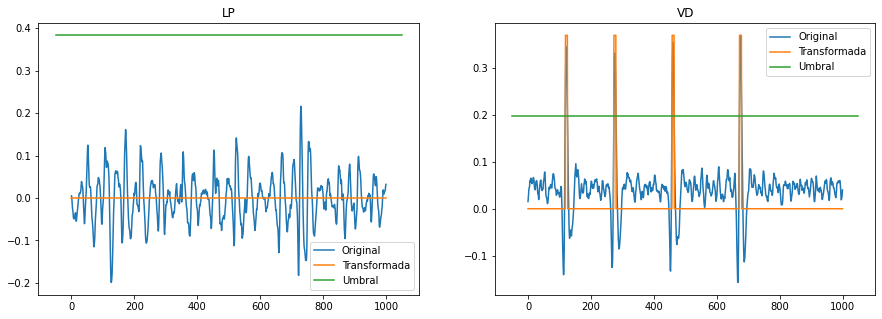

In [11]:
a = 0
b = 1000
compare_signal_and_transformation(trozoC[a:b], trozoC_t[a:b] * trozoC[a:b].max(), threshold)

Como podemos ver, en la primera serie ningún valor ha superado el umbral en los primeros 1000 puntos. Sin embargo, en la segunda serie se aprecian 4 zonas (potenciales *spikes*) donde se supera el umbral. Si cambiamos el intervalo por ejemplo a $[3000, 3500]$ podemos ver zonas donde se supera el umbral también en la primera señal.

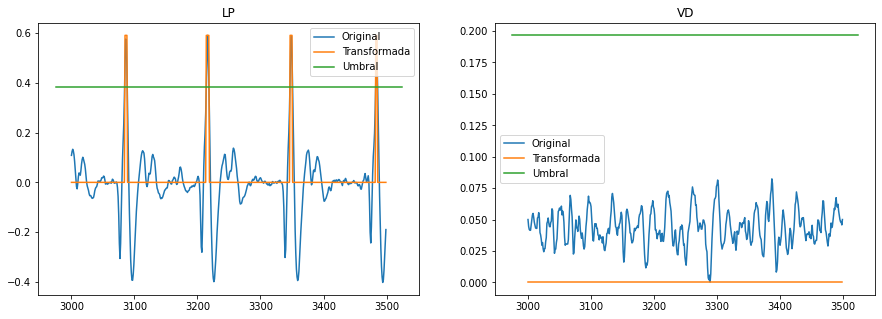

In [12]:
a = 3000
b = 3500
compare_signal_and_transformation(trozoC[a:b], trozoC_t[a:b] * trozoC[a:b].max(), threshold)

# Calcular picos

El siguiente paso es agrupar todos los 1's consecutivos que forman parte de un mismo spike en un único valor. Para ello, utilizamos la función `find_peaks` de la librería `scipy`, la cual computa todos los máximos locales de su argumento, (en caso de existir varios maximos consecutivos con el mismo valor, devuelve solo el valor central). Al utilizarla sobre nuestra serie de 0's y 1's, obtenemos una nueva serie con los puntos medios de las agrupaciones de 1's, y el resto a 0.

In [13]:
def get_peaks(df):
    """ Busca los picos correspondientes a cada columna del dataframe utilizando 
        'find_peaks'. Esta se queda con el valor medio de picos consecutivos. """
   
    # Get number of columns
    cols = df.shape[1] if len(df.shape) > 1 else 1
    
    # Return peaks array
    return np.array([find_peaks(df.iloc[:, index])[0] for index in range(cols)], dtype = object)

El número total de spikes encontrados (de forma absoluta y en porcentaje) es:

In [14]:
peaks = get_peaks(trozoC_t)
peaks_lp = len(peaks[0])
peaks_vd = len(peaks[1])
print(f"Número de spikes:\nLP: {peaks_lp}\nVD: {peaks_vd}")
print(f"% de spikes:\nLP: {100 * peaks_lp / total[0]}\nVD: {100 * peaks_vd / total[1]}")

Número de spikes:
LP: 31157
VD: 22338
% de spikes:
LP: 0.15698040579009154
VD: 0.11254704575341223


Vemos que el número de *spikes* finalmente considerados apenas supera el $0.1$%. Podemos pintar la serie original junto con los spikes considerados.

In [15]:
def compare_signal_and_peaks(df, peaks):
    """ Muestra la señal original junto con los picos considerados. """
    
    cols = df.shape[1] if len(df.shape) > 1 else 1
    fig, axs = plt.subplots(1, cols, figsize=(15,5))
    
    # Loop over columns
    for j in range(cols):
        axs[j].set_title(list(df)[j])
        
        # Get peaks for each column
        axs[j].plot(df.iloc[:, j])
        axs[j].plot(peaks[j], df.iloc[peaks[j], j], "o")
    plt.show()

Observamos los resultados en los primeros 10000 valores, viendo que los *spikes* visibles han sido correctamente capturados.

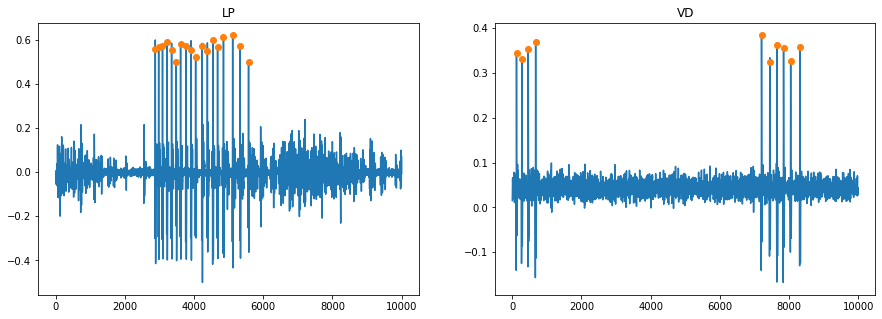

In [16]:
compare_signal_and_peaks(trozoC[0:10000], get_peaks(trozoC_t[0:10000]))

Finalmente, podemos "hacer zoom" en un spike y ver exactamente cómo se comporta nuestra transformación. Dibujaremos la serie original, la serie binaria preliminar, la recta del umbral, y finalmente los puntos que se convertirán en picos. Lo hacemos por ejemplo para la primera serie.

In [17]:
def compare_signal_transformation_and_peaks(df, df_t, peaks, threshold, j, title, offset = 0):
    """ Compara la j-ésima (j=0,1) señal original, la transformada, los 
        picos encontrados y el umbral. Comienza en la posición 'offset'. """
    
    # Get peaks for each column
    plt.plot(df.iloc[:, j], label = "Original")
    plt.plot(df_t.iloc[:, j], label = "Transformada")
    
    # Plot information
    xmin, xmax = plt.xlim()
    plt.plot([xmin, xmax], 2 * [threshold[j]], label = "Umbral")
    plt.plot(offset + peaks[j], df.iloc[peaks[j], j], "o", label = "Picos")
    plt.title(title)
    plt.legend()
    plt.show()

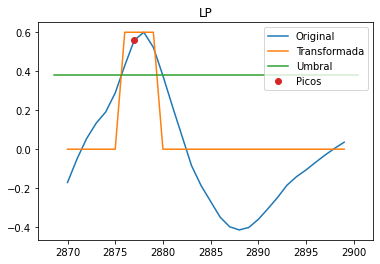

In [18]:
a = 2870
b= 2900
compare_signal_transformation_and_peaks(trozoC[a:b], 
                                        trozoC_t[a:b] * trozoC[a:b].max(), # escalado
                                        get_peaks(trozoC_t[a:b]), threshold, 
                                        j = 0, title = "LP", offset = a)

## Calcular tamaño de bin

El siguiente paso es elegir una resolución para nuestra serie, esto es, un tamaño de ventana o *bin* $\Delta t$ que represente el intervalo mínimo de medición. Buscamos que este valor sea lo suficientemente pequeño como para que en un *bin* no pueda haber más de un *spike*, de forma que nuestro cálculo posterior esté bien definido. El valor de $\Delta t$ debe ser el mismo en las dos series LP y VD.

Para establecer este valor, calculamos la distancia mínima entre *spikes* en las dos series, y tomaremos como $\Delta t$ el mínimo entre los dos valores resultantes.

In [19]:
def min_distance_between_peaks(peaks):
    """ Calcula la distancia mínima entre picos para una serie, el índice donde se 
        alcanza yel array completo de distancias entre picos. """
    
    dist = [peaks[i + 1] - peaks[i] for i in range(len(peaks) - 1)]
    min_index = np.argmin(dist)
    
    return dist[min_index], min_index, np.array(dist)

In [20]:
# Get min distance information for both series
min_dist_info = np.array([min_distance_between_peaks(p) for p in peaks], dtype = object)

# Select window accordingly
window = min(min_dist_info[:, 0])

print(f"Distancia mínima y pico donde se alcanza en cada serie:\n{min_dist_info[:, 0:2]}")
print("Ventana seleccionada:", window)

Distancia mínima y pico donde se alcanza en cada serie:
[[23 3570]
 [5 13312]]
Ventana seleccionada: 5


Podemos estudiar en cada caso las posiciones de los picos más cercanos dentro de la propia serie.

In [21]:
min_peak_position = min_dist_info[:, 1]
min_peak_position = [[peaks[i][min_peak_position[i]], peaks[i][min_peak_position[i] + 1]] 
                     for i in range(len(peaks))]
print(f"Posiciones de los picos más cercanos en LP y VD, respectivamente:\n{min_peak_position}")

Posiciones de los picos más cercanos en LP y VD, respectivamente:
[[2142183, 2142206], [12346213, 12346218]]


Pintamos ahora las series temporales con la rejilla formada al dividir en ventanas del tamaño elegido. Escogemos en cada caso un intervalo que refleje los dos *spikes* más cercanos, aquellos que han provocado que elijamos así el tamaño de ventana.

In [22]:
def plot_window(df, window, peak_position):
    """ Muestra las series junto con la rejilla formada por las ventanas.
        El intervalo será un entorno correspondiente a los spikes más cercanos 
        en cada caso, que se reciben como parámetro. """
    
    cols = df.shape[1] if len(df.shape) > 1 else 1
    fig, axs = plt.subplots(1, cols, figsize = (15,5))
    
    for j in range(cols):
        axs[j].set_title(list(df)[j])
        
        # Get peaks for each column
        axs[j].plot(df.iloc[peak_position[j][0] - 50:peak_position[j][1] + 50, j], 
                        color = "blue", label = "Original")        
        axs[j].plot(peak_position[j][0], df.iloc[peak_position[j][0], j], 
                        "o", color = "red", label = "Picos")
        axs[j].plot(peak_position[j][1], df.iloc[peak_position[j][1], j], 
                        "o", color = "red")
        
        # Plot windowed series
        xlims = [int(np.round(a)) for a in axs[j].get_xlim()]
        offset = int(window * np.round(xlims[0] / window)) 
        axs[j].vlines([offset + i for i in range(0, xlims[1] - xlims[0], window)], 
                       *axs[j].get_ylim(), color = "orange", label = "Ventana")
        
        axs[j].legend()
    plt.show()

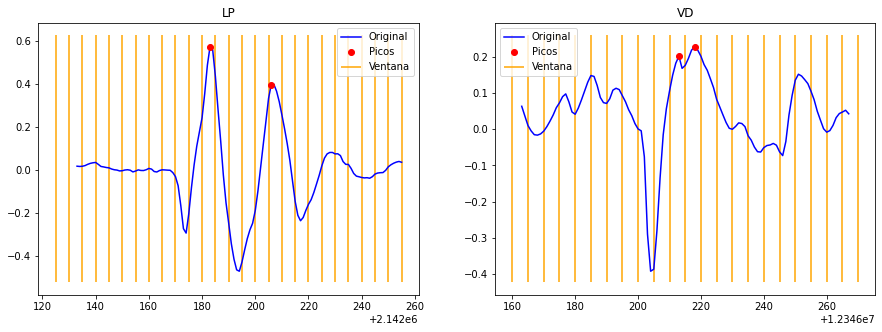

In [23]:
plot_window(trozoC, window, min_peak_position)

Finalmente, podemos hacer un histograma con todas las distancias entre picos, de forma que visualicemos el comportamiento global de los mismos. En lugar de pintar todas las distancias, pintamos solo aquellas hasta el percentil 90 para no distorsionar la figura con distancias poco frecuentes.

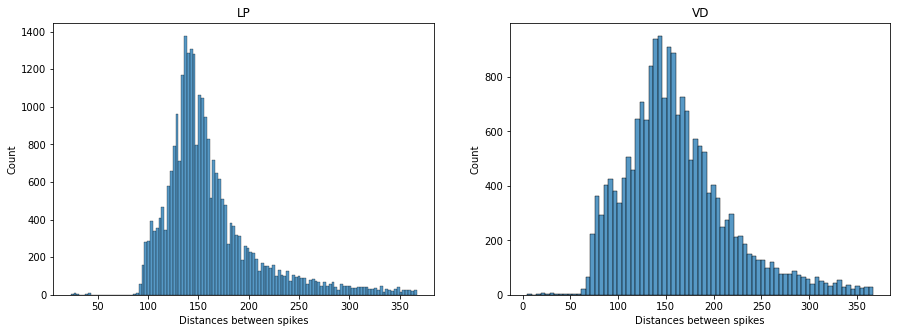

In [24]:
# Get arrays of distances
dist_arr = min_dist_info[:, 2]
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].set_title("LP")
axs[1].set_title("VD")
for ax in axs:
    ax.set_xlabel("Distances between spikes")

# Plot histogram of distances up to a threshold
percentile = np.min([np.percentile(dist_arr[i], 90) for i in range(len(dist_arr))])
sns.histplot(data=dist_arr[0][dist_arr[0] < percentile], ax = axs[0])
sns.histplot(data=dist_arr[1][dist_arr[1] < percentile], ax = axs[1])
plot = plt.plot()

Observamos que al quedarnos simplemente con la mínima distancia estamos siendo demasiado restrictivos. Los picos que se encuentran tan cercanos parecen ser *outliers* a la luz del histograma anterior. Un tamaño de ventana demasiado pequeño puede hacernos perder información mutua entre las series, por lo que vamos a proceder a ignorar estos picos que no presentan un buen comportamiento.

## Rehacer codificación con cambio de umbral y ventana

Tras el estudio de las distancias que hicimos anteriormente, decidimos no tener en cuenta para el cálculo de la ventana los picos cuya distancia es menor que 60. Como para estos últimos habrá colisiones, consideraremos como un único *spike* el caso en que haya uno o más 1's en la serie.

Por otro lado, decidimos aumentar ligeramente el umbral en la segunda serie, a la vista del siguiente histograma de valores de las series.

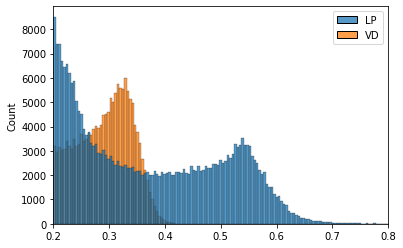

In [25]:
ax = sns.histplot(trozoC[(trozoC > 0.2) & (trozoC < 0.8)])
ax.set_xlim(0.2, 0.8)
plt.show()

Vemos que para la serie VD, la mayoría de valores están por encima del umbral fijado previamente (~$0.2$), cosa que no nos interesa. Podemos subirlo por ejemplo hasta un valor de $0.3$ para dejar más puntos por debajo, para intentar capturar mejor los *spikes*. Aplicaremos este cambio junto con el cambio de ventana que comentábamos antes.

En primer lugar, definimos una función que dado una longitud de serie y un vector con posiciones de los picos, aplica la ventana especificada transformando la serie según esa resolución.

In [26]:
def apply_window(lenght, peaks, window):
    """ Crea un vector de enteros representando la existencia de spikes en la 
        ventana prefijada de una serie temporal. Se devuelve en cada ventana
        el número de spikes que caen en ella.
        
        Argumentos:
          - lenght: longitud de la serie temporal original.
          - peaks: posición de los spikes en la serie temporal original.
          - window: tamaño de ventana. """
    
    # Initialize the new sequence with suitable length
    serie_w = np.zeros(math.ceil(lenght / window))
    
    # Get indices of each spike after applying the window
    peaks_idx = [math.floor(p / window) for p in peaks]
    
    # Compute the peaks on each window
    for i in peaks_idx:
        serie_w[i] += 1
    
    return serie_w

La siguiente función captura el cambio manual en el umbral junto con el aumento del tamaño de ventana. La escribimos de forma suficientemente general para poder reutilizarla posteriormente.

In [27]:
def codify_signal(df = None, df_t = None, peaks = None, threshold = None, window = None, plot = False, 
                  peaks_min_dist = None, compute_collisions = False):
    """ Codifica dos señales real-valuadas en señales binarias, aplicando un umbral y 
        una resolución concreta (tamaño de ventana).
    
        Entrada
        ==========
        df:                  dataframe con las series temporales originales, en su caso.
        df_t:                dataframe con las series tras aplicar el umbral, en su caso.
        peaks:               array con las posiciones de los picos tras aplicar el umbral, en su caso.
        threshold:           valor del umbral a aplicar. Si es None se calcula uno por defecto.
        window:              ventana a aplicar a la serie.
        plot:                controla si se muestra un ejemplo de gráfica de la serie con la ventana aplicada.
        peaks_min_dist:      valor mínimo a partir del cual considerar la distancia entre picos.
        compute_collisions:  controla si se calculan las colisiones en cada ventana.
        
        Salida
        ==========
        - La serie binaria codificada tras aplicar el umbral y la ventana. Aunque haya colisiones,
          se sigue considerando un único spike.
        - El tamaño de ventana fijado.
        - (Opcional) El número de colisiones encontrado en cada ventana. """
    
    if df is None and df_t is None:
        print("[Error] Se debe proporcionar al menos un dataframe.")
        return None, None
    
    # Apply threshold
    if df_t is None:
        # Compute threshold
        if threshold is None:
            threshold = compute_threshold(df)
        
        df_t = filter_with_threshold(df, threshold)
        
    # Get peaks
    if peaks is None:
        peaks = get_peaks(df_t)
    
    # Compute window as the minimum distance between spikes
    if window is None:
        min_dist_info = np.array([min_distance_between_peaks(p) for p in peaks], dtype = object)
        dist_arr = min_dist_info[:, 2]
        window = np.min(min_dist_info[:, 0])

        # Recompute window ignoring the elements with distance less than 'peaks_min_dist'.
        if peaks_min_dist is not None:
            peaks_to_erase = [np.where(d < peaks_min_dist)[0] for d in dist_arr]
            peaks_new = [np.delete(peaks[0], peaks_to_erase[0]), np.delete(peaks[1], peaks_to_erase[1])]
            min_dist_info = np.array([min_distance_between_peaks(p) for p in peaks_new], dtype = object)
            window = np.min(min_dist_info[:, 0])

        # Show the effect of windowing in the series
        if plot:
            min_peak_position = min_dist_info[:, 1]
            min_peak_position = [[peaks[i][min_peak_position[i]], peaks[i][min_peak_position[i] + 1]] 
                                 for i in range(len(peaks))]
            plot_window(df, window, min_peak_position)
    
    # Pseudo-codified, integer-valued signal (takes collisions into account)
    df_w = np.array([apply_window(df_t.shape[0], peaks[i], window) for i in range(df_t.shape[1])])
    
    # Compute collisions on each window
    count = None
    if compute_collisions:
        unique, count = np.unique(df_w, return_counts = True)
        count = np.sum(unique[unique > 1] * count[unique > 1])
    
    # Recover binary series by ignoring collisions
    df_w[df_w > 1] = 1
    
    return df_w, window, count

Aplicamos entonces el nuevo umbral, y elegimos el tamaño de ventana considerando la distancia mínima entre *spikes* solo a partir de 60, debido a la información visualizada anteriormente en el histograma de distancias.

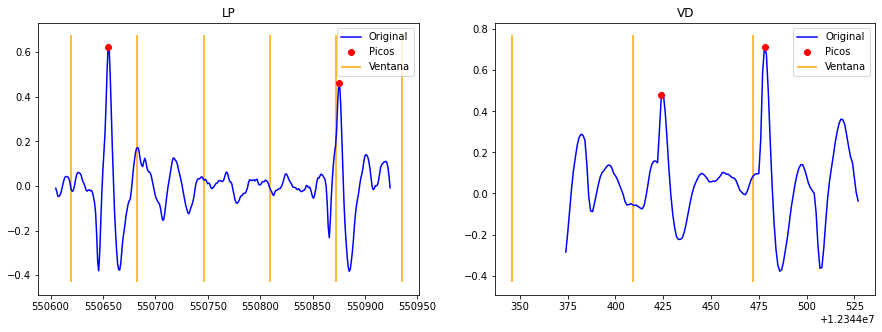

In [28]:
threshold = [threshold[0], 0.3]
trozoC_w, window, _ = \
    codify_signal(trozoC, threshold = threshold, window = None, plot = True, peaks_min_dist = 60)

Podemos comprobar la reducción de tamaño en la serie tras aplicar la ventana, observando que tenemos una serie con menos del $2$% del tamaño original.

In [29]:
print("Tamaño de ventana:", window)
print("La nueva longitud de la serie es:", len(trozoC_w[0]))
print(f"Porcentaje del tamaño original: {100 * len(trozoC_w[0]) / trozoC.shape[0]:.3f}%")

Tamaño de ventana: 63
La nueva longitud de la serie es: 315043
Porcentaje del tamaño original: 1.587%


## Calcular información mutua

La función `compute_MI` calcula la información mútua entre las diferentes series temporales existentes dentro de `serie` con ventanas de bits indicadas mediante el array `bits`.

Para cada uno de estos valores, llamemoslo `b`, computamos un array que agrupa nuestra serie en elementos del tamaño `b`. Es decir, si `b=2`:
$$
serie = \binom{0010}{1100} \implies aux = \Bigg[ \binom{00}{11}\binom{01}{10}\binom{10}{00} \Bigg]
$$
Sobre este nuevo vector (`aux`) calculamos los valores únicos que contiene (`joint_u`) y cuantas veces aparecen utilizando `np.unique` y normalizando para obtener la probabilidad de cada valor (`joint_c`).

Ahora, para cada una de las series presentes en aux:
$$
(00)(01)(10) \quad \text{  y }\quad (11)(10)(00)
$$
Calculamos los valores únicos de cada una y las probabilidades. Es decir, `solo_u[i]` contiene los valores únicos presentes en la serie i-ésima y `solo_c[i]` las probabilidades de cada uno de ellos.


Pasamos entonces al cómputo de la información mutua, supongamos que hay 2 series temporales y sea $X$ la variable aleatoria correspondiente a la primera e $Y$ la correspondiente a la segunda, entonces
$$
    MI(serie) = \int_{x,y}P(x,y) \log_2{\frac{P(x,y)}{P(x)P(y)}}.
$$
Donde, $(x,y) \in \text{joint_u}$, $x \in \text{solo_c[0]}$ y $y \in \text{solo_c[1]}$. Buscamos entonces realizar este computo de forma vectorial, utilizando que

$$
\text{joint_c} = [P(x,y) \quad \text{for } x \in Dom(x)\quad  \text{for } y \in Dom(y)  ] 
$$
De esta forma, podemos calcular el interior del logaritmo calculando el vector correspondiente a hacer las operaciones elemento a elemento.
$$
\Bigg[\frac{P(x,y)}{P(x)P(y)} \quad \text{for } x \in Dom(x)\quad  \text{for } y \in Dom(y) \Bigg] 
$$
Donde 
$$
\text{solo_c} = [[P(x) \quad \text{for } x \in Dom(x)], [P(y) \quad  \text{for } y \in Dom(y)  ]] 
$$
Podemos calcular entonces el vector $P(x)P(y)$ como el "aplanamiento" de la matriz que contiene todos los productos posibles de elementos de `x` por elementos de `y`.

La dificultad surge cuanto este nuevo vector y el vector `joint_c` no tienen las mismas dimensiones, es decir, existe combinaciones de `x` e `y` que no se ven en la serie conjunta. Por ejemplo en la serie anterior, existe el valor de `x` $(01)$ y el valor de `y` $(11)$ pero la serie no tiene el valor conjunto 
$$
\binom{01}{11}
$$

Para solucionar esto, construimos una "mascara" (`mask`) que aplicada al producto se queda solo con los elementos que existen en la serie conjunta.

Para ello, para cada valor del producto, comprobamos si es igual a la serie conjunta, esto nos devuelve arrays de `True` `False`.Por ejemplo, la probabilidad de que el primer valor del producto `prod[0]` aparezca en la serie conjunta es (utilizando `b=2`):
```
[[[ True  True]
  [ True  True]]

 [[ True  True]
  [ True False]]
.
.
.
 [[False  True]
  [False  True]]]
```
Es decir, los 4 elementos de la priemra matrix del producto, que son $(0,0),(0,0)$ coindice con los 4 elementos de la serie conjunta en la primera posición, de ahi que todos los valores sean `True`. Para obtener si existe alguna matriz en dicha salida que presente todos sus valores `True`, buscamos si se cumple que todos los elementos sean `True` en ambos ejes (`.all(axis=1).all(axis=1)`) y luego comprobamos si existe algun valor.

In [30]:
def H(X, bs = [1]):
    """ Calcula la entropía de la serie X (vista como M series unidimensionales) con ventanas
        de palabras de tamaños especificados en 'bs'.
        
        Entrada
        ==========
        X:   numpy array con tamaño (M, N), donde M es el número de series unidimensionales y 
             N el número de observaciones. Si solo hay una serie, debe ser de tamaño (1, N).
             Si M > 1, se calcula la entropía conjunta.
        bs:  lista con tamaños de ventanas de palabras.
        
        Salida
        ==========
        Array con el cálculo de la entropía para cada tamaño de palabra. """
    
    Hs = np.empty(len(bs))
        
    for j, b in enumerate(bs):
        # Pasar una ventana deslizante de tamaño 'b' por todas las series
        X_window = np.array([X[:, i:i+b] for i in range(X.shape[1] - b)])

        # Calcular el número de estados que se observan y sus probabilidades
        states, counts = np.unique(X_window, axis = 0, return_counts = True)
        probs = counts / np.sum(counts)
        
        # Calcular la entropía utilizando su fórmula
        h = -np.sum(probs * np.log2(probs))
        Hs[j] = h
    
    return Hs

Implementamos ahora la segunda estrategia para el cálculo de la información mutua, utilizando directamente la fórmula

$$
MI(X,Y)=\sum_{xy}p(x,y)\log_2\left( \frac{p(x,y)}{p(x)p(y)}\right).
$$

In [31]:
def MI_and_H(X, bs = [1], strategy = "from_entropy"):
    """ Calcula la información mutua entre dos series temporales y sus entropías
        individuales, utilizando distintos tamaños de ventanas de palabras.
        
        Entrada
        ==========
        X:         numpy array con tamaño (2, N), donde N es el número de
                   observaciones.
        bs:        lista con tamaños de ventanas de palabras.
        strategy:  puede ser "direct" para calcular la información mutua a partir
                   de su definición, o "from_entropy" para calcularla usando la
                   fórmula que la relaciona con las entropías.
        
        Salida
        ==========
        Arrays con el cálculo de la información mutua y la entropía de cada serie,
        para cada tamaño de palabra. """
    
    if strategy == "from_entropy":
        HsX = H(X[0].reshape(1, -1), bs)
        HsY = H(X[1].reshape(1, -1), bs)
        Ms = HsX + HsY - H(X, bs)
        
        return Ms, HsX, HsY
    
    elif strategy == "direct":
        HsX = np.empty(len(bs))
        HsY = np.empty(len(bs))
        Ms = np.empty(len(bs))
                          
        for j, b in enumerate(bs):
            # Pasar una ventana deslizante de tamaño 'b' por todas las series
            X_window = np.array([X[:, i:i+b] for i in range(X.shape[1] - b)])

            # Calcular el número de estados que se observan y sus probabilidades
            states_xy, counts_xy = np.unique(X_window, axis = 0, return_counts = True)
            probs_xy = counts_xy / np.sum(counts_xy)

            # Calculamos todos los estados individuales de cada serie y sus probabilidades,
            # guardando la información en arrays con dos filas (una por cada serie)
            states_marginal = []
            probs_marginal = []
            for i in range(X.shape[0]):
                states, counts = np.unique(X_window[:, i], axis = 0, return_counts = True)
                states_marginal.append(states)
                probs_marginal.append(np.array(counts / np.sum(counts)))

            # Calculamos todos los posibles productos de probabilidades de estados marginales 
            # que podrían ser observados (para el denominador dentro del logaritmo en la fórmula 
            # de MI)
            possible_products_probs = np.outer(probs_marginal[0], probs_marginal[1]).flatten()

            # Creamos una máscara para eliminar de los productos anteriores aquellos
            # correspondientes a estados que no fueron observados de forma conjunta
            possible_states = np.array([np.array([sx, sy]) 
                                        for sx in states_marginal[0] 
                                        for sy in states_marginal[1]])
            mask = ((possible_states[:, None, :, :] == states_xy).all(2)).all(2).any(1)
            
            # Calculamos la información mutua y las entropías individuales
            M = np.sum(probs_xy * np.log2(probs_xy / possible_products_probs[mask]))
            HX = -np.sum(probs_marginal[0] * np.log2(probs_marginal[0]))
            HY = -np.sum(probs_marginal[1] * np.log2(probs_marginal[1]))
            
            # Guardamos los resultados
            Ms[j] = M
            HsX[j] = HX
            HsY[j] = HY
            
        return Ms, HsX, HsY
    
    else:
        print("[Error] La estrategia de cálculo debe ser \"from_entropy\" ó \"direct\".")
        
        return None, None, None

Escribimos una función para calcular la información mutua entre las series, permitiendo elegir la estrategia y midiendo los tiempos, lo que nos permitirá comparar ambas implementaciones.

In [32]:
def compute_info(series, bs, strategy, name, verbose = True):
    """ Calcula la información mutua y la transferencia de información entre
        dos series para distintos tamaños de palabra, con la estrategia de 
        cálculo especificada. Imprime el tiempo de ejecución y opcionalmente 
        los resultados. """
    
    start = time()
    Ms, HsX, HsY = MI_and_H(series, bs, strategy)
    TXYs = Ms / HsX
    TYXs = Ms / HsY
    print(f"Tiempo total para estrategia {strategy}: {(time() - start):.1f}s")
    
    if verbose:
        print(f"Estadísticas de información en {name} con estrategia {strategy}:")
        for b, m, hx, hy, txy, tyx in zip(bs, Ms, HsX, HsY, TXYs, TYXs):
            print(f"[b = {b}]")
            print(f"  MI = {m:.5f}")
            print(f"  H(LP) = {hx:.5f}")
            print(f"  H(VD) = {hy:.5f}")
            print(f"  Transferencia LP-->VD = {txy:.5f}")
            print(f"  Transferencia VD-->LP = {tyx:.5f}")
    
    return Ms, TXYs, TYXs

También definimos un par de funciones para mostrar gráficamente los resultados.

In [33]:
def plot_I(info, bs, title, ax = None, color = 'b'):
    """ Muestra una gráfica de la medida de información proporcionada
        en función del tamaño de palabra. """
    
    if ax is None:
        fig, ax = plt.subplots()
        
    ax.plot(bs, info, color = color)
    ax.set_xlabel("Tamaño de palabra")
    ax.set_title(title)

In [34]:
def plot_info(name, bs, Ms, TXYs, TYXs):
    """ Muestra gráficas de la información mutua y la transferencia de información
        entre dos series, para distintos tamaños de palabra. """
    
    fig, axs = plt.subplots(1, 3, figsize = (15, 5))
    plt.title(name)
    plot_I(Ms, bs, "Información mutua LP<-->VD", axs[0])
    plot_I(TXYs, bs, "Transferencia LP-->VD", axs[1], 'red')
    plot_I(TYXs, bs, "Transferencia VD-->LP", axs[2], 'orange')
    plt.show()

Calculamos por fin la información mutua de las series LP y VD, utilizando tamaños de palabra variando en $\{1,\dots, 8\}$. De paso, comprobamos que se obtiene el mismo resultado con las dos estrategias implementadas, y con tiempos de ejecución similares, si bien la versión que utiliza la fórmula con las entropías es algo más rápida.

Dibujamos también la información mutua obtenida en función del tamaño de palabra, así como la transferencia de informacion $LP\to VD$ y viceversa, también en función del tamaño de palabra. Esta última medida se puede entender como una información mutua normalizada. En general, para un estímulo $S$ y una respuesta $R$, la transferencia de información del estímulo a la respuesta se puede calcular como

$$
E_{S\to R} = \frac{MI(S, R)}{H(S)}.
$$

Este valor oscila en $[0,1]$, pues $H(S)$ representa la cantidad máxima de información que se puede transmitir del estímulo a la respuesta.

Tiempo total para estrategia from_entropy: 24.2s
Estadísticas de información en trozoC con estrategia from_entropy:
[b = 1]
  MI = 0.00848
  H(LP) = 0.46532
  H(VD) = 0.35380
  Transferencia LP-->VD = 0.01823
  Transferencia VD-->LP = 0.02398
[b = 2]
  MI = 0.03716
  H(LP) = 0.92562
  H(VD) = 0.70739
  Transferencia LP-->VD = 0.04014
  Transferencia VD-->LP = 0.05253
[b = 3]
  MI = 0.06432
  H(LP) = 1.31033
  H(VD) = 1.01641
  Transferencia LP-->VD = 0.04909
  Transferencia VD-->LP = 0.06328
[b = 4]
  MI = 0.07848
  H(LP) = 1.60729
  H(VD) = 1.25354
  Transferencia LP-->VD = 0.04883
  Transferencia VD-->LP = 0.06261
[b = 5]
  MI = 0.08864
  H(LP) = 1.88212
  H(VD) = 1.46183
  Transferencia LP-->VD = 0.04710
  Transferencia VD-->LP = 0.06064
[b = 6]
  MI = 0.09765
  H(LP) = 2.13979
  H(VD) = 1.65459
  Transferencia LP-->VD = 0.04563
  Transferencia VD-->LP = 0.05902
[b = 7]
  MI = 0.10678
  H(LP) = 2.38529
  H(VD) = 1.84048
  Transferencia LP-->VD = 0.04477
  Transferencia VD-->LP = 0.0

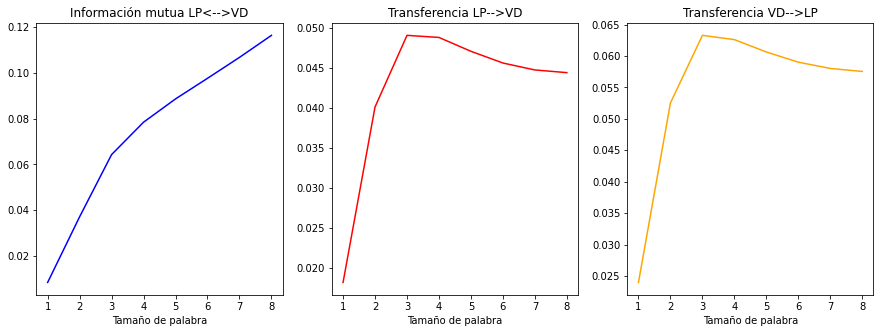

In [35]:
bs = np.arange(1, 9, 1)
Ms_entropy, TXYs, TYXs = compute_info(trozoC_w, bs, "from_entropy", "trozoC")
Ms_direct, _, _ = compute_info(trozoC_w, bs, "direct", "trozoC", verbose = False)

if np.allclose(Ms_entropy, Ms_direct):
        print("Ambas estrategias proporcionan los mismos resultados.")
        
plot_info("trozoC", bs, Ms_entropy, TXYs, TYXs)

Análisis de MI frente a tamaño word.

$E_{S\to R}=0$ implica que toda la información se pierde, mientras que $E_{S\to R}=1$ implica que hay una completa sincronización entre estímulo y respuesta. En nuestro caso, $E_{LP\to VD}$ queda un poco por debajo de $E_{VD\to LP}$ para todos los tamaños de palabra, y ambas tienen valores pequeños (pues la MI es pequeña en comparación con las entropías). Sin embargo, ninguna es 0, por lo que podemos afirmar que se transmite algo de información en ambos sentidos, siendo esta transferencia ligeramente mayor desde la neurona VD a la LP.

## Búsqueda del tamaño óptimo de ventana y palabra

In [112]:
def process_word(b, n, df_t, peaks):
    """ Compute MI and collisions for varying window sizes, for a given word size 'b'. """
    
    MIs = []
    cs = []
    
    for w in np.arange(5, n + 1, 5):
        df_w, _, collisions = \
            codify_signal(df_t = trozoC_t, peaks = peaks, window = w, compute_collisions = True)
        MIs.append(MI_and_H(df_w, [b])[0][0])
        cs.append(collisions)
        
    return MIs, cs, b

In [100]:
""" Callback for progress bar in parallel jobs """

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    # Context manager to patch joblib to report into tqdm progress bar given as argument
    class TqdmBatchCompletionCallBack(joblib.parallel.BatchCompletionCallBack):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n = self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallBack
    
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()  

In [ ]:
threshold[1] = 0.3
trozoC_t = filter_with_threshold(trozoC, threshold)
peaks = get_peaks(trozoC_t)
n = 600
bs = np.arange(1, 9)

# Parallel execution for each word size
num_cores = multiprocessing.cpu_count()
#with tqdm_joblib(tqdm(total = len(bs))) as progress_bar:
#    results = Parallel(n_jobs = num_cores)(delayed(process_word)(b, n, trozoC_t, peaks) for b in bs)

In [ ]:
fig, axs = plt.subplots(8, 3, figsize = (15, 30))
for i, r in enumerate(results):
    b = r[2]
    axs[i, 0].set_title(f"IM en función de bin, {b} bit(s)")
    axs[i, 1].set_title(f"IM/(Bin*Word) en función de bin, {b} bit(s)")
    axs[i, 2].set_title(f"Colisiones en función de bin")
        
    axs[i, 0].plot(np.arange(5, n + 1, 5), r[0])
    axs[i, 1].plot(np.arange(5, n + 1, 5), r[0] /(np.arange(5, n + 1, 5) * b), color = "red")
    axs[i, 2].plot(np.arange(5, n + 1, 5), r[1], color = "orange")

## Cambio de codificación

Usamos *bursts*. Blabla

Tal y como hicimos originalmente para fijar el umbral cuando codificábamos *spikes*, seguiremos un proceso en dos etapas para fijar cuántos *spikes* consideramos que debe haber como mínimo en un *burst* (a este número lo llamaremos $\rho$). En primer lugar, tras el análisis visual y estadístico de los datos y las distancias entre *spikes* que hicimos antes, fijamos un valor *a priori* de $\rho_0=5.$ En base a este valor vamos a elegir un tamaño de ventana adecuado. El razonamiento que hacemos es el siguiente: tomamos para cada serie (LP y VD) las medianas de las distancias entre picos consecutivos, y hacemos la media de los dos valores obtenidos$^\ast$. Para encontrar *bursts*, que hemos dicho que como mínimo tendrían $5$ *spikes*, necesitaríamos tomar un tamaño de ventana de $5$ veces la estimación realizada. Además de esto, multiplicamos la mediana por un factor corrector de $1.5$ para dejar más márgen de encontrar *bursts* de mayor longitud.

($\ast$) Utilizamos la mediana en vez de la media por ser más robusta a *outliers*. La suposición general que hacemos es que los *spikes* vienen mayormente en grupos o *bursts*, de forma mucho más frecuente que aislados. Por esto tiene sentido utilizar la mediana como medida estadística relevante para decidir el tamaño de ventana.

In [95]:
spikes_per_burst_priori = 5
dist_arr = [[ps[i + 1] - ps[i] for i in range(len(ps) - 1)] for ps in peaks]
window_burst = spikes_per_burst_priori * np.mean([1.5 * np.median(d) for d in dist_arr])
print("Ventana a priori para medir bursts:", window_burst)

Ventana a priori para medir bursts: 1203.75


Usando este tamaño de ventana, vamos a decidir cuál es el valor *a posteriori* del número de *spikes* por *burst* que vamos a fijar. Para ello, calculamos para el tamaño de ventana fijado cuántos spikes caen en cada bin (únicamente cuando al menos cae un *spike* en ese bin), y hacemos la media de la distribución obtenida. Finalmente, aplicamos un factor corrector a este valor, y el resultado redondeado al alza será el número de *spikes* que consideramos que hay como mínimo en un *burst*.

In [96]:
def compute_spikes_per_burst(df, threshold, window_burst):
    df_t = filter_with_threshold(df, threshold)
    peaks = get_peaks(df_t)
    df_w = np.array([apply_window(df_t.shape[0], peaks[i], window_burst) for i in [0, 1]])
    unique, count = np.unique(df_w, return_counts = True)
        
    return math.ceil(np.sum(unique * count) / np.sum(count[1:]))

In [97]:
spikes_per_burst = compute_spikes_per_burst(trozoC, threshold, window_burst)
print("Número mínimo de spikes por burst:", spikes_per_burst)

Número mínimo de spikes por burst: 5


Podemos calcular la información mutua y la transferencia de información de la serie con los parámetros fijados hasta el momento; es decir, la ventana preliminar y el número mínimo de *spikes* por *burst*. Para ello definimos una función que nos permita codificar la presencia de *bursts* como eventos de interés.

In [98]:
def codify_bursts(df_t, window, peaks, spikes_per_burst):
    df_w = np.array([apply_window(df_t.shape[0], peaks[i], window) for i in [0, 1]])
        
    return np.array(filter_with_threshold(pd.DataFrame(df_w), spikes_per_burst))

Calculamos ya la información mutua y la transferencia de información variando el tamaño de palabra.

Tiempo total para estrategia from_entropy: 0.9s


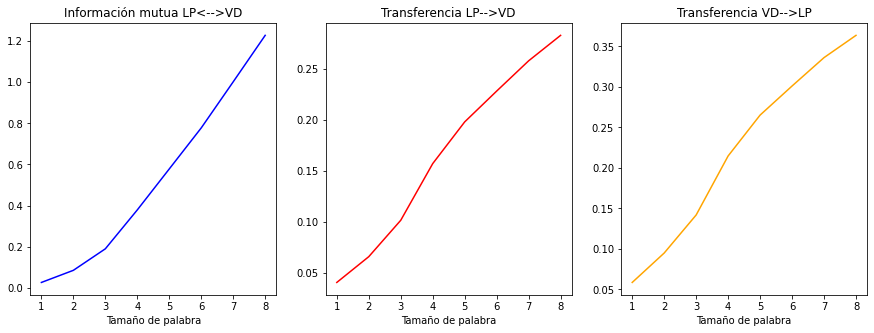

In [99]:
bs = np.arange(1, 9, 1)
trozoC_t = filter_with_threshold(trozoC, threshold)
peaks = get_peaks(trozoC_t)
trozoC_w_bursts = codify_bursts(trozoC_t, window_burst, peaks, spikes_per_burst)
Ms, TXYs, TYXs = compute_info(trozoC_w_bursts, bs, "from_entropy", "trozoC_bursts", verbose = False)
plot_info("trozoC con bursts", bs, Ms, TXYs, TYXs)

In [109]:
def process_word_burst(b, n, df_t, peaks, spikes_per_burst):
    """ Calcula la información mutua variando el tamaño de ventana, para un número 
        fijo 'b' de bits de palabra. En este caso los eventos que llevan la información
        son los bursts. """
    
    MIs = []
    
    for w in np.arange(5, n + 1, 25):
        df_w = codify_bursts(trozoC_t, w, peaks, spikes_per_burst)
        MIs.append(MI_and_H(df_w, [b])[0][0])
        
    return MIs, b

In [110]:
n = 10000

# Parallel execution for each word size
num_cores = multiprocessing.cpu_count()
with tqdm_joblib(tqdm(total = len(bs))) as progress_bar:
    results = Parallel(n_jobs = num_cores)(delayed(process_word_burst)(b, n, trozoC_t, peaks, spikes_per_burst) 
                for b in bs)

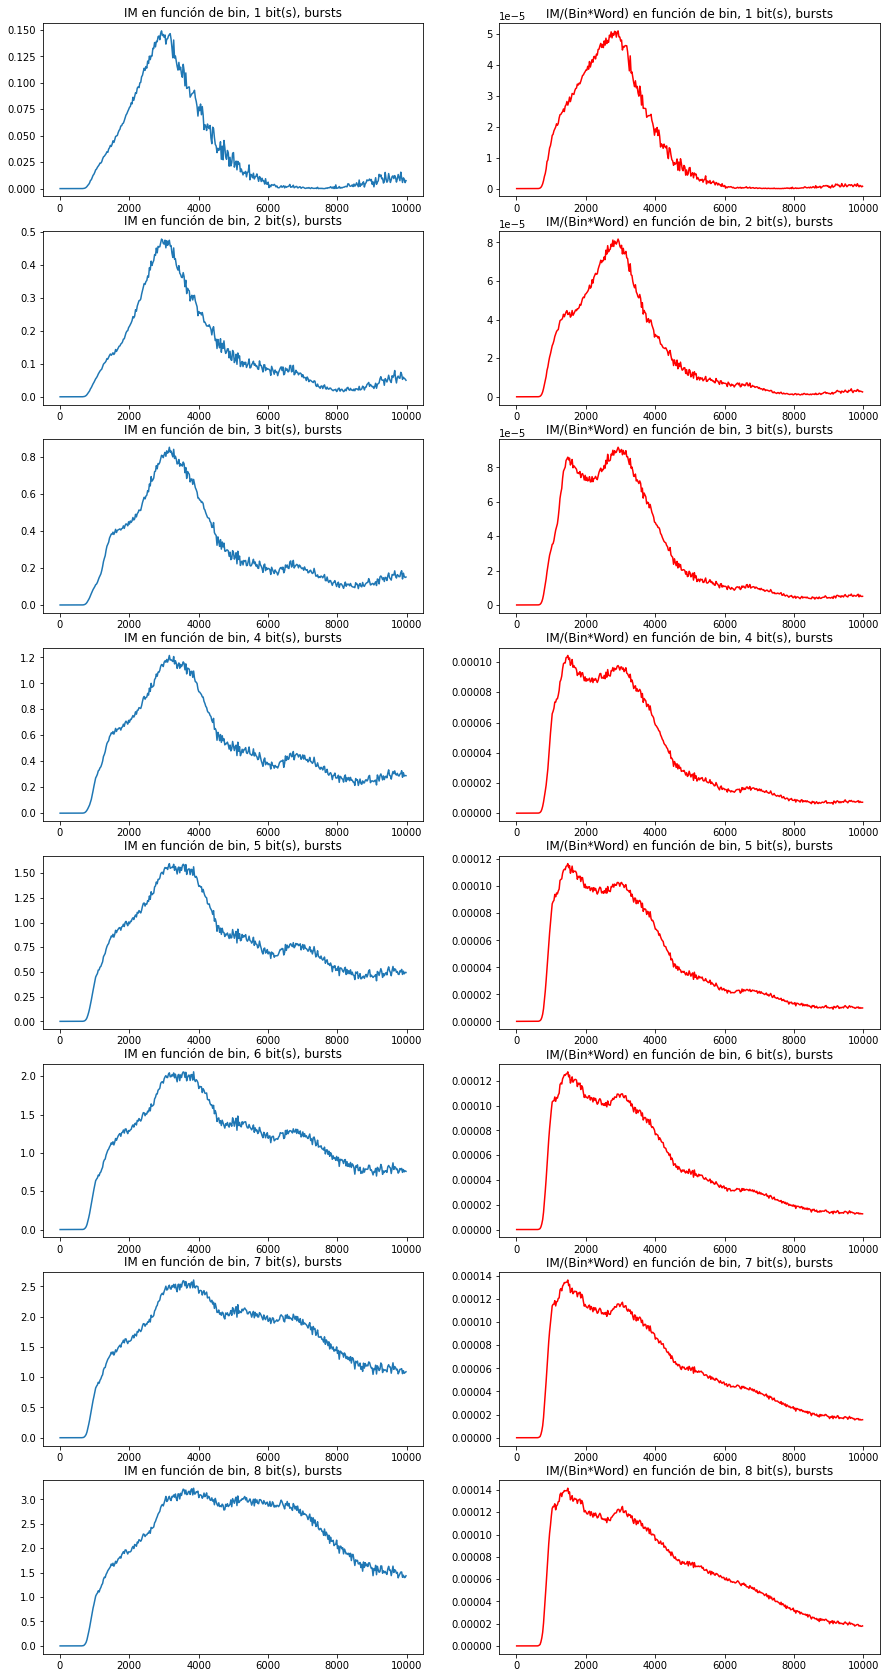

In [111]:
fig, axs = plt.subplots(8, 2, figsize = (15, 30))
for i, r in enumerate(results):
    b = r[1]
    axs[i, 0].set_title(f"IM en función de bin, {b} bit(s), bursts")
    axs[i, 1].set_title(f"IM/(Bin*Word) en función de bin, {b} bit(s), bursts")
        
    axs[i, 0].plot(np.arange(5, n + 1, 25), r[0])
    axs[i, 1].plot(np.arange(5, n + 1, 25), r[0] / (np.arange(5, n + 1, 25) * b), color = "red")

## TrozoG

## TrozoR

## Conclusiones